In [2]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

import cv2

%matplotlib inline

In [3]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

# UMAP

In [3]:
import umap

In [5]:
t0 = time.time()
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time.time()-t0))

Duration: 0.07341241836547852


In [15]:
t0 = time.time()
reducer = umap.UMAP(n_neighbors=60,min_dist=0,n_components=3)
X = reducer.fit_transform(pca_loadings[:,:10])
print('Duration: {}'.format(time.time()-t0))

Duration: 25.988946676254272


# Cluster

In [7]:
import hdbscan

In [16]:
lines4cluster = []
for i in range(X.shape[0]-1):
    lines4cluster.append(tuple(X[i:i+2,0]) + tuple(X[i:i+2,1]) + tuple(X[i:i+2,2]))
lines4cluster = np.asarray(lines4cluster)

In [17]:
min_cluster_size=10
min_samples=30
cluster_selection_epsilon=.5

t0 = time.time()
lines_clustered = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    cluster_selection_epsilon=cluster_selection_epsilon,
                                    cluster_selection_method='leaf').fit(lines4cluster)
lines_clustered.labels_ += 1
labels = lines_clustered.labels_
num_zeros = len(np.where(lines_clustered.labels_ == 0)[0])
num_points = len(lines_clustered.labels_)

print('{} clusters. {:0.0f}% timepoints in a cluster.'.format(
    max(lines_clustered.labels_),num_zeros/num_points*100))

28 clusters. 66% timepoints in a cluster.


In [5]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
          '#000000']

# Or, just load pre-clustered

In [6]:
file = os.path.join(directory, 'tsne', '20191222_X_labels.npy')
labels=np.load(file)
file = os.path.join(directory, 'tsne', '20191222_X.npy')
X=np.load(file)

# Visualize

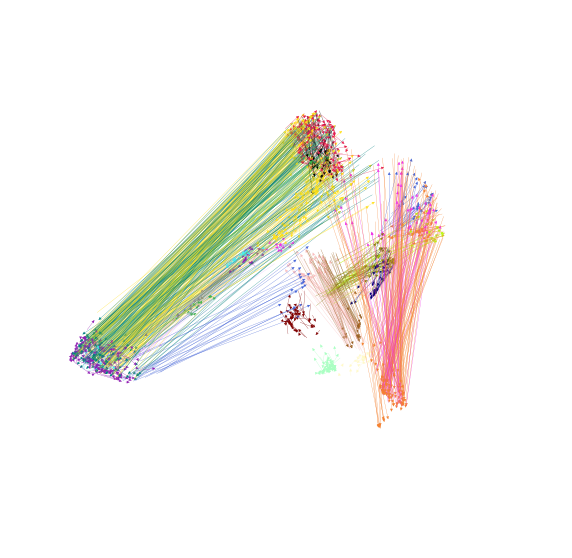

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X[:,0], X[:,1], X[:,2],marker='o',s=1,zorder=1,color='k',alpha=0.25)
for i in range(X.shape[0]-1):
    if labels[i] == 0:
        alpha = 0
        color='#000000'
    else:
        alpha = 1
        color=colors[labels[i]%len(colors)]
    a = Arrow3D(X[i:i+2,0],X[i:i+2,1],X[i:i+2,2],
                mutation_scale=6,lw=0.25,arrowstyle="-|>",
                color=color,alpha=alpha)
    ax.add_artist(a)
    #ax.plot(X[i:i+2,0],
    #        X[i:i+2,1],
    #        X[i:i+2,2],
    #         alpha=alpha,
    #         lw=1,
    #         #solid_capstyle='butt',
    #         c=colors[lines_clustered.labels_[i]%len(colors)],
    #         zorder=0)
window = 2.5
center = np.mean(X,axis=0)
ax.set_xlim(center[0]-window,center[0]+window)
ax.set_ylim(center[1]-window,center[1]+window)
ax.set_zlim(center[2]-window,center[2]+window)
ax.margins(x=0, y=0)
#ax.set_proj_type('ortho')
plt.axis('off')
ax.view_init(0,0)

# for k,angle in enumerate(range(360)):
#     print(angle)
#     ax.view_init(0,angle)
#     fname = os.path.join(save_path, '{0:05d}.png'.format(k))
#     plt.savefig(fname,dpi=300,bbox_inches='tight')

# Load Video

In [7]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.64 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.94 sec


In [8]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac/fictrac-20190218_133014-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<90000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


In [9]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [10]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

In [1]:
3

3

In [ ]:
3

In [ ]:
# a reasonable looking rate of rotation is 20deg/sec
# Here, we have 20 frames a sec, so just update 1deg/frame!

In [ ]:
save_path = os.path.join(directory,'tsne','videos','20191222_2')
#os.mkdir(save_path)

start_ms = int(19.5*60*1000)
stop_ms = int(start_ms + 5*60*1000) # seconds to ms
step_ms = 50
NUM_FRAMES = int((stop_ms-start_ms)/step_ms)
VIDEO_TIMEPOINTS = np.arange(start_ms,stop_ms,step_ms)
#NUM_FRAMES=1

for i in range(150,NUM_FRAMES):
    
    fig = plt.figure(figsize=(10,7))
    fig_ratio = 10/7

    ax1 = fig.add_subplot(111, projection='3d')
    window = 2
    center = np.mean(X,axis=0)
    ax1.set_xlim(center[0]-window,center[0]+window)
    ax1.set_ylim(center[1]-window,center[1]+window)
    ax1.set_zlim(center[2]-window,center[2]+window)
    ax1.margins(x=0, y=0)
    ax1.axis('off')
    ax1.view_init(0,0)

    ax2 = fig.add_axes([0.7, .45, 0.2, 0.8]) # fly movie
    ax2.axis('off')

    print('{} of {}'.format(i,NUM_FRAMES))
    brain_idx = np.searchsorted(timestamps[:,20], VIDEO_TIMEPOINTS[i])
    behavior_idx = np.searchsorted(xnew, VIDEO_TIMEPOINTS[i])
    
    ### PLOT UMAP
    for j in range(X.shape[0]-1):
        if labels[j] == 0:
            alpha = 0
            color='#000000'
        else:
            alpha = 1
            color=colors[labels[j]%len(colors)]
        if j==brain_idx:
            lw=4
            alpha=1
        else:
            lw=0.25
        a = Arrow3D(X[j:j+2,0],X[j:j+2,1],X[j:j+2,2],
                    mutation_scale=6,lw=lw,arrowstyle="-|>",
                    color=color,alpha=alpha)
        ax1.add_artist(a)
        
    ### PLOT FLY
    ax2.imshow(frames[behavior_idx][25:225,250:550,:])
    
    ax1.view_init(0,i%360)
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

150 of 6000
151 of 6000
152 of 6000
153 of 6000
154 of 6000
155 of 6000
156 of 6000
157 of 6000
158 of 6000
159 of 6000
160 of 6000
161 of 6000
162 of 6000
163 of 6000
164 of 6000
165 of 6000
166 of 6000
167 of 6000
168 of 6000
169 of 6000
170 of 6000
171 of 6000
172 of 6000
173 of 6000
174 of 6000
175 of 6000
176 of 6000
177 of 6000
178 of 6000
179 of 6000
180 of 6000
181 of 6000
182 of 6000
183 of 6000
184 of 6000
185 of 6000
186 of 6000
187 of 6000
188 of 6000
189 of 6000
190 of 6000
290 of 6000
291 of 6000
292 of 6000
293 of 6000
294 of 6000
295 of 6000
296 of 6000
297 of 6000
298 of 6000
299 of 6000
300 of 6000
301 of 6000
302 of 6000
303 of 6000
304 of 6000
305 of 6000
306 of 6000
307 of 6000
308 of 6000
309 of 6000
310 of 6000
311 of 6000
312 of 6000
313 of 6000
314 of 6000
315 of 6000
316 of 6000
317 of 6000
318 of 6000
319 of 6000
320 of 6000
321 of 6000
322 of 6000
323 of 6000
324 of 6000
325 of 6000
326 of 6000
327 of 6000
328 of 6000
329 of 6000
330 of 6000
331 of 6000
332 

932 of 6000
933 of 6000
934 of 6000
935 of 6000
936 of 6000
937 of 6000
938 of 6000
939 of 6000
940 of 6000
941 of 6000
942 of 6000
943 of 6000
944 of 6000
945 of 6000
946 of 6000
947 of 6000
948 of 6000
949 of 6000
950 of 6000
951 of 6000
952 of 6000
953 of 6000
954 of 6000
955 of 6000
956 of 6000
957 of 6000
958 of 6000
959 of 6000
960 of 6000
961 of 6000
962 of 6000
963 of 6000
964 of 6000
965 of 6000
966 of 6000
967 of 6000
968 of 6000
969 of 6000
970 of 6000
971 of 6000
972 of 6000
973 of 6000
974 of 6000
975 of 6000
976 of 6000
977 of 6000
978 of 6000
979 of 6000
980 of 6000
981 of 6000
982 of 6000
983 of 6000
984 of 6000
985 of 6000
986 of 6000
987 of 6000
988 of 6000
989 of 6000
990 of 6000
991 of 6000
992 of 6000
993 of 6000
994 of 6000
995 of 6000
996 of 6000
997 of 6000
998 of 6000
999 of 6000
1000 of 6000
1001 of 6000
1002 of 6000
1003 of 6000
1004 of 6000
1005 of 6000
1006 of 6000
1007 of 6000
1008 of 6000
1009 of 6000
1010 of 6000
1011 of 6000
1012 of 6000
1013 of 6000
10

In [31]:
0%360

0

In [2]:
start_ms

NameError: name 'start_ms' is not defined

In [1]:
9

9